In [1]:
from urllib import request
import zipfile
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

Accessing data:

In [2]:
DATASET_URL = 'http://files.grouplens.org/datasets/movielens/ml-100k.zip'
DATASET_ARCHIVE = 'ml-100k.zip'

request.urlretrieve(DATASET_URL, DATASET_ARCHIVE)
with zipfile.ZipFile(DATASET_ARCHIVE) as archive:
    archive.extractall()

# Exploratory Analysis 

### YOUR TASK:
1. Check readme file (especially DETAILED DESCRIPTIONS OF DATA FILES section)
2. What do we need to do for EDA, before starting building the model?

This data set consists of:
   * 100,000 ratings (1-5) from 943 users on 1682 movies. 
   * Each user has rated at least 20 movies. 

In [3]:
users_num = 943
movies_num = 1682

How our data looks?

In [4]:
df = pd.read_csv('ml-100k/u.data', header=None, names=['user_id', 'item_id', 'rating', 'timestamp'], 
                 delim_whitespace=True)

In [5]:
df.head()

,user_id,item_id,rating,timestamp
0,196,242,3,881250949
1,186,302,3,891717742
2,22,377,1,878887116
3,244,51,2,880606923
4,166,346,1,886397596


In [6]:
df.tail()

,user_id,item_id,rating,timestamp
99995,880,476,3,880175444
99996,716,204,5,879795543
99997,276,1090,1,874795795
99998,13,225,2,882399156
99999,12,203,3,879959583


Check if every pair (user, item) appears only once

In [7]:
df.groupby(['user_id','item_id']).count().reset_index()['timestamp'].max()

1

Check for nan

In [8]:
df['rating'].unique()

array([3, 1, 2, 4, 5])

Ratings distribution

<Axes: ylabel='Frequency'>

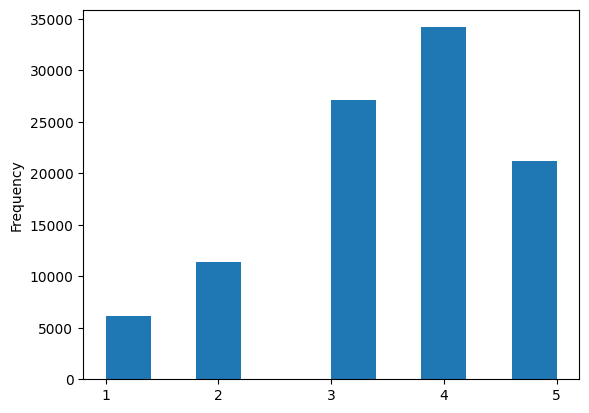

In [9]:
df['rating'].plot.hist(xticks=[1,2,3,4,5])

Choose one movie from u.info file and check its ratings

<Axes: ylabel='Frequency'>

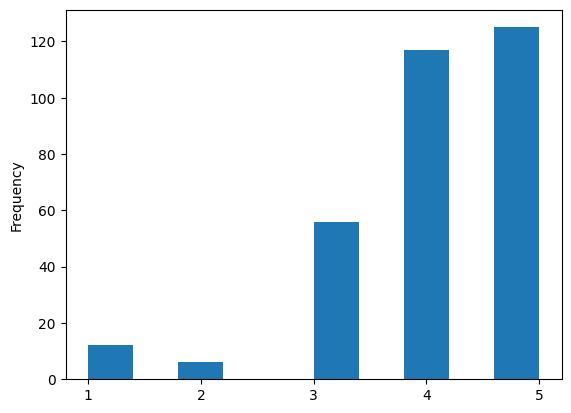

In [10]:
df[df.item_id == 168]['rating'].plot.hist(xticks=[1,2,3,4,5])

#### Sparsity

In [11]:
grouped = df[['user_id', 'item_id']].groupby('user_id').count() \
            .rename(columns={'item_id' : 'rating_count' }).sort_values('rating_count',ascending=False)
grouped.head()

,rating_count
user_id,
405,737
655,685
13,636
450,540
276,518


In [12]:
grouped['sparsity'] = 1.0 - grouped.rating_count / float(movies_num)
print(grouped.head())
print(grouped.tail())

         rating_count  sparsity
user_id                        
405               737  0.561831
655               685  0.592747
13                636  0.621879
450               540  0.678954
276               518  0.692033
         rating_count  sparsity
user_id                        
685                20  0.988109
475                20  0.988109
36                 20  0.988109
732                20  0.988109
596                20  0.988109


In [13]:
np.average(grouped['sparsity'])

0.9369533063577546

<Axes: ylabel='Frequency'>

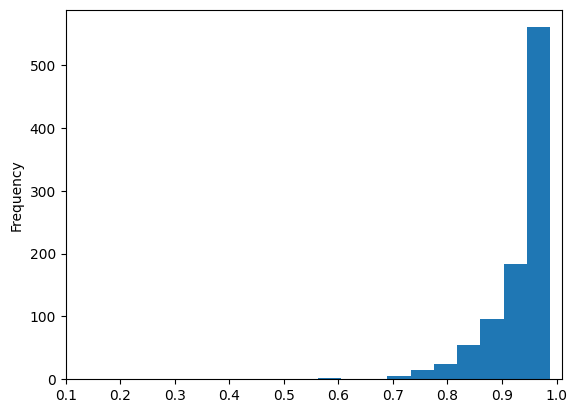

In [14]:
grouped['sparsity'].plot.hist(xticks=[i*0.1 for i in range(1,11)])

<Axes: ylabel='Frequency'>

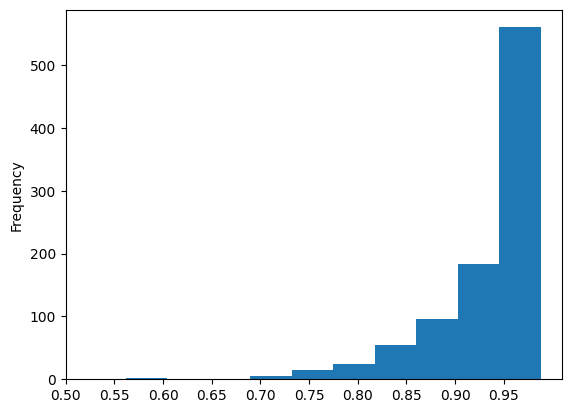

In [15]:
grouped['sparsity'].plot.hist(xticks=[0.5+i*0.05 for i in range(10)])

Reindex ids to numpy's like

In [16]:
[(df[x].min(),df[x].max()) for  x in ['user_id', 'item_id']]

[(1, 943), (1, 1682)]

In [17]:
for col in  ['user_id', 'item_id']:
    df[col] = df[col]-1

In [18]:
[(df[x].min(),df[x].max()) for  x in ['user_id', 'item_id']]

[(0, 942), (0, 1681)]

# User-User CF

Firstly we want to have our data in form of matrix, where rows coresponds to users, columns to items and values to ratings

YOUR TASK:
1. get reccomendation matrix, where users are in rows and movies are in columns
2. What to do with missing values (i.e. pairs of users,movie that have no rating in our dataset)?
3. We want this matrix to be called 'ratings_matrix' and be a np.ndarray type

tip: check dataframe.pivot or pd.crosstab

In [19]:
ratings_matrix = np.zeros((users_num, movies_num), dtype='int32')
for i, j, v, _ in df.values:
    ratings_matrix[i, j] = v
print(ratings_matrix)

[[5 3 4 ... 0 0 0]
 [4 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [5 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 5 0 ... 0 0 0]]


Similarity functions:
* Jackard similarity
* cosine similarity
* Pearson correlation

In [20]:
def jackard_similarity_distance(M):
    n,k = M.shape
    distance_matrix = np.zeros([n,n])
    for i in range(n):
        for j in range(n):
            vec_sum = float(np.count_nonzero(M[i]+M[j]))
            if vec_sum == 0:
                distance_matrix[i,j]= 1
            else:
                distance_matrix[i,j] = 1 - np.count_nonzero(M[i]*M[j]) / vec_sum
    return distance_matrix

In [21]:
jackard_similarity_distance(ratings_matrix)

array([[0.        , 0.94303797, 0.97484277, ..., 0.96478873, 0.91666667,
        0.767507  ],
       [0.94303797, 0.        , 0.91588785, ..., 0.90909091, 0.90697674,
        0.95927602],
       [0.97484277, 0.91588785, 0.        , ..., 0.94444444, 0.92741935,
        0.99090909],
       ...,
       [0.96478873, 0.90909091, 0.94444444, ..., 0.        , 0.95876289,
        0.97297297],
       [0.91666667, 0.90697674, 0.92741935, ..., 0.95876289, 0.        ,
        0.91666667],
       [0.767507  , 0.95927602, 0.99090909, ..., 0.97297297, 0.91666667,
        0.        ]])

## YOUR TASK
1. Implement cosine_similarity_distance based on jackard_similarity_distance
2. Implement scipy_pearson_similarity_distance based on jackard_similarity_distance

In [25]:
def cosine_similarity_distance(M):
    n,k = M.shape
    distance_matrix = np.array(np.zeros([n,n]))
    for i, r1 in enumerate(M):
        for j, r2 in enumerate(M):
            distance_matrix[i, j] = 1 - np.dot(r1, r2)/(np.sqrt(np.sum(r1 ** 2)) * np.sqrt(np.sum(r2 ** 2)))
    return distance_matrix # n x n matrix, where M is n x k matrix

In [26]:
cosine_similarity_distance(ratings_matrix)

array([[ 0.00000000e+00,  8.33069016e-01,  9.52540457e-01, ...,
         8.51383057e-01,  8.20492117e-01,  6.01825261e-01],
       [ 8.33069016e-01, -2.22044605e-16,  8.89408675e-01, ...,
         8.38515222e-01,  8.27732187e-01,  8.94202122e-01],
       [ 9.52540457e-01,  8.89408675e-01,  0.00000000e+00, ...,
         8.98757435e-01,  8.66583851e-01,  9.73444131e-01],
       ...,
       [ 8.51383057e-01,  8.38515222e-01,  8.98757435e-01, ...,
         0.00000000e+00,  8.98358201e-01,  9.04880419e-01],
       [ 8.20492117e-01,  8.27732187e-01,  8.66583851e-01, ...,
         8.98358201e-01, -2.22044605e-16,  8.17535338e-01],
       [ 6.01825261e-01,  8.94202122e-01,  9.73444131e-01, ...,
         9.04880419e-01,  8.17535338e-01, -2.22044605e-16]])

#### Can we upgrade this cosine similarity?

In [27]:
from scipy.stats import pearsonr
def scipy_pearson_similarity_distance(M):
    n,k = M.shape
    distance_matrix = np.array(np.zeros([n,n]))
    for i, r1 in enumerate(M):
        for j, r2 in enumerate(M):
            distance_matrix[i, j] = 1- pearsonr(r1, r2).statistic
    return distance_matrix # n x n matrix, where M is n x k matrix

In [28]:
scipy_pearson_similarity_distance(ratings_matrix)

KeyboardInterrupt: 

## YOUR TASK
1. Implement knn that takes similarity_function as one of the inputs
2. The function should return idx, sorted_dist - two matrixes:
 * idx of shape n x k that contains indexes of simmilar users
 * sorted_dist of shape n x k that contains distances to these users


In [21]:
def knn(ratings_matrix, k, similarity_function):
    dist_matrix = similarity_function(ratings_matrix)
    idx = np.argsort(dist_matrix)[:, 1:k+1]
    sortest_dist = np.take_along_axis(dist_matrix, idx, axis=1)
    return idx, sorted_dist # two n x k matrix

## YOUR TASK
1. implement calculate_recommendation function - it should return reccomendation_matrix
<!--
def calculate_recommendation(ratings_matrix, neighbors, distances):
    u,k = neighbors.shape
    p = ratings_matrix.shape[1]
    rating_matrix_ind = np.array(ratings_matrix!=0, dtype=float)
    recommendation_matrix = np.zeros([u,p])
    for i in range(u):
        for j in range(p):
            numerator = np.sum((1-distances[i,:])*ratings_matrix[neighbors[i],j])
            denominator = np.sum((1-distances[i,:])*rating_matrix_ind[neighbors[i],j])
            if(denominator==0):
                recommendation_matrix[i,j] = 0
            else:
                recommendation_matrix[i,j] = numerator / float(denominator)
    return recommendation_matrix
<!--
def get_recommendation(recommendation_matrix, n):
    rating_ind = np.array(ratings_matrix!=0, dtype=float)
    recommendation = np.argsort(-np.multiply(recommendation_matrix,1-rating_ind))[:,:n]
    ratings = np.take_along_axis(recommendation_matrix, recommendation, axis=1) 
    return recommendation, ratings
!-->

In [22]:
def calculate_recommendation(ratings_matrix, neighbors, distances):
     #insert your code here ~ 8-12 lines
    return recommendation_matrix # same shape as ratings_matrix filled with our prediction

In [24]:
def get_recommendation(recommendation_matrix, n):
    # insert your code here ~ 3 lines
    return recommendation, ratings # n recommendations for every user and estimated ratings

# Item-Item CF

YOUR TASK:
1. What we have to change in order to change user-user into item-item approach?

<!-- 

def calculate_recommendation_item_based(ratings_matrix, item_neighbors, item_distances): # to get arguments run previous knn 
    # on ratings_item_matrix
    p,k = item_neighbors.shape
    u = ratings_matrix.shape[0]
    rating_matrix_ind = np.array(ratings_matrix!=0, dtype=float)
    recommendation_matrix = np.array(np.zeros(u*p))
    recommendation_matrix.shape = (u,p)
    for i in range(u):
        for j in range(p):
            numerator = np.sum((1-item_distances[j,:])*ratings_matrix[i,item_neighbors[j]])
            denominator = np.sum((1-item_distances[j,:])*rating_matrix_ind[i, item_neighbors[j]])
            if(denominator==0):
                recommendation_matrix[i,j] = 0
            else:
                recommendation_matrix[i,j] = numerator / float(denominator)
    return recommendation_matrix

-->


<!-- This is commented out. -->

In [27]:
def calculate_recommendation_item_based(ratings_matrix, item_neighbors, item_distances):
    #insert your code here ~ 8-12 lines (most code can be pasted from previous calculate_recommendation)
    return recommendation_matrix

### RMSE

#### YOUR TASK:

1. Implement rmse function. it should take ratings_matrix (ground truth), recommendation_matrix (given by model) and information where the test cases are (test_ind). All input matrixes are of the same shape

In [35]:
def rmse(ratings_matrix,recommendation_matrix, test_ind):
    #insert your code here ~ 2-4 lines
    return output

# Testing

In [28]:
train_1 = pd.read_csv('ml-100k/u1.base', header=None, names=['user_id', 'item_id', 'rating', 'timestamp'], 
                 delim_whitespace=True)
test_1 = pd.read_csv('ml-100k/u1.test', header=None, names=['user_id', 'item_id', 'rating', 'timestamp'], 
                 delim_whitespace=True)

In [29]:
for col in  ['user_id', 'item_id']:
    train_1[col] = train_1[col]-1
    test_1[col] = test_1[col]-1

In [30]:
train_1_ratings_matrix = np.matrix(pd.crosstab(index=pd.Categorical(train_1['user_id'],categories = [i for i in range(943)]), 
                              columns=pd.Categorical(train_1['item_id'],categories = [i for i in range(1682)]),
                             values=train_1['rating'], aggfunc=np.sum, dropna= False).fillna(0).values)
test_1_ratings_matrix = np.matrix(pd.crosstab(index=pd.Categorical(test_1['user_id'],categories = [i for i in range(943)]), 
                              columns=pd.Categorical(test_1['item_id'],categories = [i for i in range(1682)]),
                             values=test_1['rating'], aggfunc=np.sum, dropna= False).fillna(0).values)

#### YOUR TASK:

1. Check if train + test is equal to full data_set

In [ ]:
#insert your code here ~ 1-2 lines

#### YOUR TASK:

1. How to check what is the base line for the model?

<!--
neighbors, distances = knn(train_1_ratings_matrix, 3, cosine_similarity_distance)
recommendation_matrix = calculate_recommendation(train_1_ratings_matrix, neighbors, distances)
ratings_matrix_ind =  np.array(ratings_matrix!=0, dtype=float)
a,b =ratings_matrix_ind.shape
print (a,b)
dumb_pred = np.random.randint(1,6, size=a*b)
dumb_pred.shape=(a,b)
dumb_pred
rmse(ratings_matrix, dumb_pred,ratings_matrix_ind)
-->

In [34]:
#insert your code here ~ 5-6 lines

# Validation

In [43]:
def cross_val_testing(ratings_matrix):
    results =[]
    print("start")
    for ii in range(1,6):
        iter_start_time = time.time()
        train = pd.read_csv('ml-100k/u{}.base'.format(ii), header=None, names=['user_id', 'item_id', 'rating', 'timestamp'], 
                             delim_whitespace=True)
        test = pd.read_csv('ml-100k/u{}.test'.format(ii), header=None, names=['user_id', 'item_id', 'rating', 'timestamp'], 
                             delim_whitespace=True)

        for col in  ['user_id', 'item_id']:
            train[col] = train[col]-1
            test[col] = test[col]-1
        
        train_ratings_matrix = np.array(pd.crosstab(index=pd.Categorical(train['user_id'],categories = [i for i in range(943)]), 
                                                    columns=pd.Categorical(train['item_id'],categories = [i for i in range(1682)]),
                                                    values=train['rating'], aggfunc=np.sum, dropna= False).fillna(0).values)
        test_ratings_matrix = np.array(pd.crosstab(index=pd.Categorical(test['user_id'],categories = [i for i in range(943)]), 
                                                    columns=pd.Categorical(test['item_id'],categories = [i for i in range(1682)]),
                                                    values=test['rating'], aggfunc=np.sum, dropna= False).fillna(0).values)
        
        train_ratings_item_matrix = np.array(pd.crosstab(index=pd.Categorical(train['item_id'],categories = [i for i in range(1682)]), 
                                                    columns=pd.Categorical(train['user_id'],categories = [i for i in range(943)]),
                                                    values=train['rating'], aggfunc=np.sum, dropna= False).fillna(0).values)       
        
        train_ind = np.array(train_ratings_matrix!=0, dtype=float)
        test_ind = np.array(test_ratings_matrix!=0, dtype=float)
        
        print('Precalc time: ',  round((time.time()-iter_start_time)/60.0,3) )
        
        for k in [5,7,40]:        
            for function_name,dist_function in zip(['jackard','cosine','better_cosine','pearson'],[jackard_similarity_distance, cosine_similarity_distance, better_cosine_similarity_distance, scipy_pearson_similarity_distance]):
                for cf_type,rec_fun in zip(['u-u','i-i'],[calculate_recommendation, calculate_recommendation_item_based]):                       
                    start_time = time.time()
                    neighbors, distances = knn(train_ratings_matrix, k, dist_function) if cf_type =='u-u' \
                                        else knn(train_ratings_item_matrix, k, dist_function)
                    recommendation_matrix = rec_fun(train_ratings_matrix, neighbors, distances)
                    rmse_val = rmse(ratings_matrix, recommendation_matrix, test_ind)
                    results.append([ii,cf_type,function_name,k, rmse_val, round((time.time()-start_time)/60.0,3)])
                    print ([ii,cf_type,function_name,k, rmse_val, round((time.time()-start_time)/60.0,3)])
        print("Iter time: ", iter_start_time)
    return results

In [3]:
result = cross_val_testing(ratings_matrix)